In [2]:
# Import Modules
!pip install yfinance
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import math
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

     |████████████████████████████████| 6.4 MB 7.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Instructions for updating:
non-resource variables are not supported in the long term


# Data Processing

### Normalize Data

In [4]:
# Normalize Data Within Window (min-max)
def normalize_in_window(data):
  new_data = []
  for j in range(len(data)):
    prices = []
    volumes = []
    for i in range(len(data[j])):
      if (i + 1) % 5 == 0:
        volumes.append(data[j][i])
      else:
        prices.append(data[j][i])
    maxprice = max(prices)
    minprice = min(prices)
    maxvol = max(volumes)
    minvol = min(volumes)
    newrow = []
    price_index = 0
    vol_index = 0
    for k in range(len(data[j])):
      if (k + 1) % 5 == 0:
        newrow.append((volumes[vol_index] - minvol)/(maxvol-minvol))
        vol_index += 1
      else:
        newrow.append((prices[price_index] - minprice)/(maxprice - minprice))
        price_index += 1
    newrow.append(maxprice)
    newrow.append(minprice)
    new_data.append(newrow)
  data = np.array(new_data)
  return data

# Normalize Over the Training Timeframe (min-max)
def normalize_all(data, train_window):
  prices = []
  volumes = []
  for j in range(train_window):
    for i in range(len(data[j])):
      if (i + 1)%5 == 0:
        volumes.append(data[j][i])
      else:
        prices.append(data[j][i])
  maxprice = max(prices)
  minprice = min(prices)
  minvol = min(volumes)
  maxvol = max(volumes)
  print('Max Price:', maxprice)
  print('Min Price:', minprice)
  new_data = []
  for k in range(len(data)):
    row = []
    for i in range(len(data[k])):
      if (i + 1)%5 == 0:
        row.append((data[k][i]-minvol)/(maxvol-minvol))
      else:
        row.append((data[k][i]-minprice)/(maxprice-minprice))
    new_data.append(row)
  return np.array(new_data)

# Standardize over the whole Training Timeframe (0 mean, 1std)
def standardize_all(data):
  prices = []
  volumes = []
  for j in range(len(data)):
    for i in range(len(data[j])):
      if (i + 1)%5 == 0:
        volumes.append(data[j][i])
      else:
        prices.append(data[j][i])
  meanprice = np.average(np.array(prices))
  stdprice = np.std(np.array(prices))
  meanvol = np.sum(np.array(volumes))/len(prices)
  stdvol = np.std(np.array(volumes))
  print('Mean Price:', meanprice)
  print('STD Price:', stdprice)
  new_data = []
  for k in range(len(data)):
    row = []
    for i in range(len(data[k])):
      if (i + 1)%5 == 0:
        row.append((data[k][i]-meanvol)/(stdvol))
      else:
        row.append((data[k][i]-meanprice)/(stdprice))
    new_data.append(row)
  return np.array(new_data)

def log_normalization(data):
  return np.log(data)

### yfinance Data Processsing

In [166]:
# Get Data From Yfinance
def getData(ticker, input_interval, input_candles, output_interval):

  # Load Input Data
  # Input Data Columns: Date, Open, High, Low, Close, Volume
  input = yf.download(ticker, interval=input_interval)
  input = np.array(pd.DataFrame({'Date': input.index, 'Open': input.values[:, 0], 'High': input.values[:, 1],
                         'Low': input.values[:, 2], 'Close': input.values[:, 3],
                         'Volume': input.values[:, 5]}))
  # Output Data Colums: Date, Low
  # Load Output Data
  output = yf.download(ticker, interval=output_interval)
  output = np.array(pd.DataFrame({'Date': output.index, 'Low': output.values[:, 2]}))
  
  # Match Input w/ Output
  # Matched Data Columns: Repeat (Date, Open, High, Low, Close, Volume) for each input candle, Output Low
  data = []
  input_dates = list(input[:, 0])
  for row in output:
    data_row = []
    outdate = row[0]
    try:
      input_index = input_dates.index(outdate)
      # Collect the input_candles preceeding the outdate
      for i in range(input_candles):
        candle = input[input_index - 1 - i][1:]
        for item in candle:
          data_row.append(item)
      data_row.append(row[1])
      data.append(data_row)
    except: 
      pass
  return np.array(data)

In [167]:
# Get Data
data = getData("SPY", "1d", 10, "1d")
print(data.shape)
data = normalize_all(data, 7000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(7374, 51)
Max Price: 429.6600036621094
Min Price: 42.8125


### Intraday Data Processing

In [ ]:
# Intraday Process (5min to Predict 1hr)
input_data = np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/5min.csv', header=None))
output_data = np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/1hr.csv', header=None))
data = []
deleted = []
i = 0
output_data = output_data[1:]
index = 0
while True:
  try:
    # Select 24 candles of data
    selection = input_data[i: i+24][:, 1:]
    last_timestamp = input_data[i: i+24][:, 0][23]
    # Check last candle, if it doesn't match up we just omit from dataset b/c we have a lot of datapoints
    if int(last_timestamp[14:16]) == 55:
      selection = list(selection.flatten())
      selection.append(output_data[index][1])
      data.append(selection)
      i += 12
    else:
      deleted.append(index)
      difference = int(last_timestamp[14:16]) + 60 - 55
      i += int(12 - difference/5)
    index += 1
  except:
    break

data = np.array(data)
print(data.shape)
print(deleted)
data = normalize_all(data, 33000)

(34671, 121)
[7, 15, 39, 47, 55, 71, 79, 95, 111, 127, 135, 143, 159, 167, 175, 191, 199, 207, 208, 223, 231, 239, 255, 263, 271, 295, 303, 311, 312, 319, 327, 351, 383, 423, 431, 455, 503, 511, 527, 544, 551, 559, 607, 615, 623, 631, 655, 663, 679, 695, 703, 719, 775, 783, 791, 807, 815, 823, 830, 831, 847, 855, 863, 880, 887, 895, 903, 912, 920, 927, 935, 943, 951, 967, 975, 976, 983, 991, 999, 1007, 1015, 1039, 1047, 1055, 1071, 1079, 1095, 1119, 1127, 1151, 1160, 1167, 1191, 1207, 1231, 1239, 1247, 1263, 1271, 1279, 1287, 1303, 1367, 1391, 1431, 1479, 1495, 1503, 1519, 1711, 1727, 1815, 1820, 1821, 1861, 1965, 1973, 1981, 1997, 2030, 2069, 2077, 2125, 2181, 2221, 2309, 2373, 2405, 2469, 2525, 2573, 2581, 2605, 2629, 2677, 2693, 2717, 2838, 2861, 2973, 3018, 3051, 3171, 3275, 3324, 3403, 3619, 3771, 3824, 3833, 3913, 3930, 3986, 3993, 4009, 4073, 4113, 4153, 4177, 4297, 4441, 4545, 5022, 5821, 5822, 5988, 5989, 7043, 7044, 7045, 7869, 8012, 8013, 9877, 10028, 10029, 11885, 16060, 16

In [61]:
# 1hr to predict 1d
from pandas import Timestamp
input_data = np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/1hrinput.csv', header=None))
output = yf.download('SPY', interval='1d')
output_data = np.array(pd.DataFrame({'Date': output.index, 'Low': output.values[:, 2]}))
outdates = list(output_data[:, 0])
start = outdates.index(Timestamp('2005-01-05 00:00:00'))
output_data = output_data[start:]
data = []
deleted = []
i = 0
index = 0
while True:
  try:
    # Select 24 candles of data
    selection = input_data[i: i+24][:, 1:]
    last_timestamp = input_data[i: i+24][:, 0][23]
    # Check last candle, if it doesn't match up we just omit from dataset b/c we have a lot of datapoints
    if int(last_timestamp[11:13]) == 19:
      selection = list(selection.flatten())
      selection.append(output_data[index][1])
      data.append(selection)
      i += 12
    else:
      deleted.append(index)
      difference = int(last_timestamp[11:13]) - 7
      i += int(12 - difference)
    index += 1
  except:
    break
data = np.array(data)
print(data.shape)
data = log_normalization(data)

[*********************100%***********************]  1 of 1 completed
(4167, 121)


In [5]:
#1hr to predict 1hr
input_data = np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/1hrinputandoutput.csv', header=None))
output_data = input_data[:, 3]
data = []
index = 0
output_data = output_data[10:]
for i in range(len(output_data)):
  row = input_data[i: i+10, 1:]
  row = row.flatten()
  row = list(row)
  row.append(output_data[i])
  data.append(row)
data = np.array(data)
print(data.shape)
data = normalize_all(data, 66000)

(68208, 51)
Max Price: 450.094
Min Price: 52.0695


### Split Data

In [9]:
# Split Train/Test based on time frame (simulates predicting the future using past data)
x = data[:, [i for i in range(50)]]
y = np.transpose([data[:, 50]])
X_train, X_test, Y_train, Y_test = np.transpose(x[:66000]), np.transpose(x[66000:]), np.transpose(y[:66000]), np.transpose(y[66000:])

# Single Layer RNN

In [179]:
# Create Mini-Batches
def random_mini_batches(X, Y, mini_batch_size=64):
  mini_batches = []
  m = X.shape[1]
  num_complete_mini_batches = math.floor(m/mini_batch_size)
  for k in range(num_complete_mini_batches):
    batch_X = X[:, k*mini_batch_size: (k+1)*mini_batch_size]
    batch_Y = Y[:, k*mini_batch_size: (k+1)*mini_batch_size]
    mini_batches.append((batch_X, batch_Y))
  if m % mini_batch_size != 0:
    batch_X = X[:, mini_batch_size * num_complete_mini_batches:]
    batch_Y = Y[:, mini_batch_size * num_complete_mini_batches:]
    mini_batches.append((batch_X, batch_Y))
  return mini_batches

In [180]:
def create_placeholders(n_x, n_y):
  X = tf.placeholder(tf.float32, shape=[n_x, None], name='Placeholder_1')
  Y = tf.placeholder(tf.float32, shape=[n_y, None], name='Placeholder_2')
  h_prev = tf.placeholder(tf.float32, [8, 1], name='h_prev')
  return X, Y, h_prev


In [181]:
X, Y, h_prev = create_placeholders(8, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))
print(h_prev)

X = Tensor("Placeholder_1_1:0", shape=(8, ?), dtype=float32)
Y = Tensor("Placeholder_2_1:0", shape=(1, ?), dtype=float32)
Tensor("h_prev:0", shape=(8, 1), dtype=float32)


In [182]:
import tensorflow as tf2

def initialize_parameters(parameter_size, hidden_size):
  Wa = tf.get_variable("Wa", [hidden_size, parameter_size], initializer = tf2.initializers.GlorotNormal())
  Wya = tf.get_variable("Wya", [1, hidden_size], initializer = tf2.initializers.GlorotNormal())
  Waa = tf.get_variable("Waa", [hidden_size, hidden_size], initializer = tf2.initializers.GlorotNormal())

 

  ba = tf.get_variable("ba", [hidden_size, 1], initializer=tf.zeros_initializer())
  by = tf.get_variable("by", [1, 1], initializer=tf.zeros_initializer())
  parameters = {
      "Wa": Wa,
      "Wya": Wya,
      "Waa": Waa,
      "ba": ba,
      "by": by,
  }
  return parameters

In [183]:
def forward_propagation(X, parameters, h_prev, max_batch):
  Wa = parameters["Wa"]
  Wya = parameters["Wya"]
  Waa = parameters["Waa"]
  ba = parameters["ba"]
  by = parameters["by"]
 
  a, y = {}, []
  a[-1] = h_prev
  for t in range(max_batch):
    try:
      a[t] = tf.nn.relu(tf.add(tf.add(ba, tf.matmul(Waa, a[t - 1])), tf.matmul(Wa, X[:, t:t+1])))
      yt = tf.nn.relu(tf.add(tf.matmul(Wya, a[t]), by))
      y.append(yt)
    except:
      pass
  return y, a

In [184]:
def compute_cost(predictions, Y):
  cost = tf.reduce_mean(tf.math.abs(tf.subtract(predictions, Y)))
  return cost

In [187]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 500, print_cost = True, minibatch_size=16):
  ops.reset_default_graph()
  (n_x, m) = X_train.shape
  n_y = Y_train.shape[0]
  costs = []
  
  X, Y, h_prev = create_placeholders(n_x, n_y)
  parameters = initialize_parameters(n_x, 8)
  preds, h = forward_propagation(X, parameters, h_prev, minibatch_size)
  cost = compute_cost(preds, Y)
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
  init = tf.global_variables_initializer()

  print("Beginning Training")
  with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
      hprevious = np.zeros((8, 1))
      epoch_cost = 0                      # Defines a cost related to an epoch
      num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
      for i in range(num_minibatches):
          # Select a minibatch
          (minibatch_X, minibatch_Y) = minibatches[i]
          _, minibatch_cost, h_new = sess.run([optimizer, cost, h], feed_dict={X: minibatch_X, Y: minibatch_Y, h_prev: hprevious})
          epoch_cost += minibatch_cost
          hprevious = h_new[list(h.keys())[-1]]
      epoch_cost/=num_minibatches

      # Print the cost every epoch
      if print_cost == True and epoch % 100 == 0:
          print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
      if print_cost == True and epoch % 5 == 0:
          costs.append(epoch_cost)

    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save parameters
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")

    
    return parameters, hprevious

In [ ]:
parameters, h = model(X_train, Y_train, X_test, Y_test)

In [ ]:
def compute_accuracy(X, Y, parameters, hprevious):
  Wa = parameters["Wa"]
  Wya = parameters["Wya"]
  Waa = parameters["Waa"]
  ba = parameters["ba"]
  by = parameters["by"]
  a, y = {}, []
  a[-1] = hprevious
  for t in range(X.shape[1]):
    a[t] = np.maximum(np.add(np.add(ba, np.matmul(Waa, a[t - 1])), np.matmul(Wa, X[:, t:t+1])), 0)
    yt = np.maximum(np.add(np.matmul(Wya, a[t]), by), 0)
    y.append(yt)


  error = 0
  for i in range(len(y)):
    error += abs(y[i] - Y[0][i])
  print('MAE on Normalized Data', error/len(y))


  # Convert prediction back into actual prediction
  mre = 0
  for i in range(len(y)):
    maxprice = 450.6300048828125
    minprice = 42.8125
    actual_predict = y[i]*(maxprice - minprice) + minprice
    true_price = Y[0][i]*(maxprice - minprice) + minprice
    #print(actual_predict, true_price)
    mre += abs(actual_predict - true_price)/(true_price)
  print('MRE on Actual Prices:', mre[0][0]/len(y))

compute_accuracy(X_test, Y_test, parameters, h)

MAE on Normalized Data [[0.01034523]]
MRE on Actual Prices: 0.009823926364928532


# Two Layer RNN

In [ ]:
def create_placeholders(n_x, n_y):
  X = tf.placeholder(tf.float32, shape=[n_x, None], name='Placeholder_1')
  Y = tf.placeholder(tf.float32, shape=[n_y, None], name='Placeholder_2')
  h_prev = tf.placeholder(tf.float32, [8, 1], name='h_prev')
  h2_prev = tf.placeholder(tf.float32, [4, 1], name='h2_prev')
  return X, Y, h_prev, h2_prev


In [ ]:
X, Y, h_prev, h2_prev = create_placeholders(4, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))
print(h_prev)
print(h2_prev)

X = Tensor("Placeholder_1_2:0", shape=(4, ?), dtype=float32)
Y = Tensor("Placeholder_2_2:0", shape=(1, ?), dtype=float32)
Tensor("h_prev_2:0", shape=(8, 1), dtype=float32)
Tensor("h2_prev_2:0", shape=(8, 1), dtype=float32)


In [ ]:
import tensorflow as tf2

def initialize_parameters(parameter_size, hidden_size):
  Wa = tf.get_variable("Wa", [hidden_size, parameter_size], initializer = tf2.initializers.GlorotNormal())
  Wya = tf.get_variable("Wya", [hidden_size, hidden_size], initializer = tf2.initializers.GlorotNormal())
  Waa = tf.get_variable("Waa", [hidden_size, hidden_size], initializer = tf2.initializers.GlorotNormal())

  Wa2 = tf.get_variable("Wa2", [4, hidden_size], initializer = tf2.initializers.GlorotNormal())
  Wya2 = tf.get_variable("Wya2", [1, 4], initializer = tf2.initializers.GlorotNormal())
  Waa2 = tf.get_variable("Waa2", [4, 4], initializer = tf2.initializers.GlorotNormal())

  ba = tf.get_variable("ba", [hidden_size, 1], initializer=tf.zeros_initializer())
  ba2 = tf.get_variable("ba2", [4, 1], initializer=tf.zeros_initializer())
  by = tf.get_variable("by", [hidden_size, 1], initializer=tf.zeros_initializer())
  by2 = tf.get_variable("by2", [1, 1], initializer=tf.zeros_initializer())
  parameters = {
      "Wa": Wa,
      "Wya": Wya,
      "Waa": Waa,
      "ba": ba,
      "by": by,
      "Wa2": Wa2,
      "Wya2": Wya2,
      "Waa2": Waa2,
      "ba2": ba2,
      "by2": by2
  }
  return parameters

In [ ]:
def forward_propagation(X, parameters, h_prev, h2_prev, max_batch):
  Wa = parameters["Wa"]
  Wya = parameters["Wya"]
  Waa = parameters["Waa"]
  ba = parameters["ba"]
  by = parameters["by"]
  Wa2 = parameters["Wa2"]
  Wya2 = parameters["Wya2"]
  Waa2 = parameters["Waa2"]
  ba2 = parameters["ba2"]
  by2 = parameters["by2"]
  a, a2, y = {}, {}, []
  a[-1] = h_prev
  a2[-1] = h2_prev
  for t in range(max_batch):
    try:
      a[t] = tf.nn.relu(tf.add(tf.add(ba, tf.matmul(Waa, a[t - 1])), tf.matmul(Wa, X[:, t:t+1])))
      yt = tf.nn.relu(tf.add(tf.matmul(Wya, a[t]), by))
      a2[t] = tf.nn.relu(tf.add(tf.add(ba2, tf.matmul(Waa2, a2[t - 1])), tf.matmul(Wa2, yt)))
      yt2 = tf.nn.relu(tf.add(tf.matmul(Wya2, a2[t]), by2))
      y.append(yt2)
    except:
      pass
  return y, a, a2

In [ ]:
def compute_cost(predictions, Y):
  cost = tf.reduce_mean(tf.math.abs(tf.subtract(predictions, Y)))
  return cost

In [ ]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, num_epochs = 1000, print_cost = True, minibatch_size=8):
  ops.reset_default_graph()
  (n_x, m) = X_train.shape
  n_y = Y_train.shape[0]
  costs = []
  
  X, Y, h_prev, h2_prev = create_placeholders(n_x, n_y)
  parameters = initialize_parameters(n_x, 8)
  preds, h, h2 = forward_propagation(X, parameters, h_prev, h2_prev, minibatch_size)
  cost = compute_cost(preds, Y)
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
  init = tf.global_variables_initializer()

  print("Beginning Training")
  with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
      hprevious = np.zeros((8, 1))
      h2previous = np.zeros((4, 1))
      epoch_cost = 0                      # Defines a cost related to an epoch
      num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
      for i in range(num_minibatches):
          # Select a minibatch
          (minibatch_X, minibatch_Y) = minibatches[i]
          _, minibatch_cost, h_new, h2_new = sess.run([optimizer, cost, h, h2], feed_dict={X: minibatch_X, Y: minibatch_Y, h_prev: hprevious, h2_prev: h2previous})
          epoch_cost += minibatch_cost
          hprevious = h_new[list(h.keys())[-1]]
          h2previous = h2_new[list(h.keys())[-1]]
      epoch_cost/=num_minibatches

      # Print the cost every epoch
      if print_cost == True and epoch % 100 == 0:
          print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
      if print_cost == True and epoch % 5 == 0:
          costs.append(epoch_cost)

    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Save parameters
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")

    
    
    return parameters, hprevious, h2previous

Beginning Training
Cost after epoch 0: 0.144653
Cost after epoch 100: 0.005205
Cost after epoch 200: 0.004715
Cost after epoch 300: 0.004512
Cost after epoch 400: 0.004501
Cost after epoch 500: 0.004506
Cost after epoch 600: 0.004503
Cost after epoch 700: 0.004484
Cost after epoch 800: 0.004449
Cost after epoch 900: 0.004469


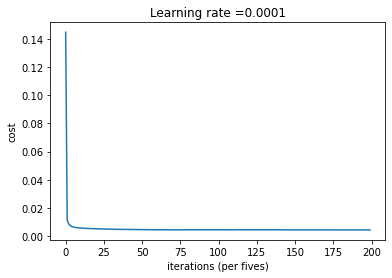

Parameters have been trained!


In [ ]:
parameters, h, h2 = model(X_train, Y_train, X_test, Y_test)

In [ ]:
def compute_accuracy(X, Y, parameters, hprevious, h2previous):
  Wa = parameters["Wa"]
  Wya = parameters["Wya"]
  Waa = parameters["Waa"]
  ba = parameters["ba"]
  by = parameters["by"]
  Wa2 = parameters["Wa2"]
  Wya2 = parameters["Wya2"]
  Waa2 = parameters["Waa2"]
  ba2 = parameters["ba2"]
  by2 = parameters["by2"]
  a, a2, y = {}, {}, []
  a[-1] = hprevious
  a2[-1] = h2previous
  for t in range(X.shape[1]):
    a[t] = np.maximum(np.add(np.add(ba, np.matmul(Waa, a[t - 1])), np.matmul(Wa, X[:, t:t+1])), 0)
    yt = np.maximum(np.add(np.matmul(Wya, a[t]), by), 0)
    a2[t] = np.maximum(np.add(np.add(ba2, np.matmul(Waa2, a2[t - 1])), np.matmul(Wa2, yt)), 0)
    yt2 = np.maximum(np.add(np.matmul(Wya2, a2[t]), by2), 0)
    y.append(yt2)


  error = 0
  for i in range(len(y)):
    error += abs(y[i] - Y[0][i])
  print('MAE on Normalized Data', error/len(y))


  # Convert prediction back into actual prediction
  mre = 0
  for i in range(len(y)):
    maxprice = 429.6400146484375
    minprice = 42.8125
    actual_predict = y[i]*(maxprice - minprice) + minprice
    true_price = Y[0][i]*(maxprice - minprice) + minprice
    #print(actual_predict, true_price)
    mre += abs(actual_predict - true_price)/(true_price)
  print('MRE on Actual Prices:', mre[0][0]/len(y))

compute_accuracy(X_test, Y_test, parameters, h, h2)

MAE on Normalized Data [[0.00938141]]
MRE on Actual Prices: 0.00847949196308995


# CNN

In [6]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, RNN
from keras.callbacks import EarlyStopping
from keras.models import Model, load_model
from keras.initializers import glorot_uniform, glorot_normal

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [10]:
# Format X data to fit in CNN
# Format: m sets of 5xdx1 matricies, where d is the number of candles in the window
def format(X, d):
  # Each window is a column of X
  new_X = []
  for i in range(len(X[0])):
    col = X[:, i]
    sample = np.zeros((5, 1))
    # Every 5 datapoints in the column is one column in the sample
    bar_data = []
    for j in range(len(col)):
      bar_data.append(col[j])
      if (j + 1) % 5 == 0:
        sample = np.concatenate((sample, np.transpose([np.array(bar_data)])), axis=1)
        bar_data = []
    sample = np.delete(sample, 0, axis=1)
    sample = np.expand_dims(sample, 2)
    new_X.append(sample)
  return np.array(new_X)
X_train = format(X_train, 10)
print(X_train.shape)
Y_train = np.squeeze(Y_train)

(66000, 5, 10, 1)


In [11]:
from keras.layers.convolutional import Conv3D
from keras.layers.recurrent import SimpleRNN
from keras.layers import ConvLSTM2D
from keras.layers import Reshape

def basic_cnn(input_shape = (5, 10, 1)):
  tf.compat.v1.disable_eager_execution()
  X_input = Input(input_shape)
  X = Conv2D(filters=5, kernel_size=(3, 3), padding='valid', kernel_initializer=glorot_normal())(X_input)
  X = Conv2D(filters=5, kernel_size=(3, 3), padding='valid', kernel_initializer=glorot_normal())(X_input)
  X = Flatten()(X)
  X = Dense(128, activation='relu', kernel_initializer=glorot_normal())(X)
  X = Dense(64, activation='relu', kernel_initializer=glorot_normal())(X)
  X = Dense(32, activation='relu', kernel_initializer=glorot_normal())(X)
  X = Dense(16, activation='relu', kernel_initializer=glorot_normal())(X)
  X = Dense(1, activation='relu', kernel_initializer=glorot_normal())(X)
  model = Model(inputs = X_input, outputs = X, name='BasicCNN')
  return model

In [12]:
X_test = format(X_test, 10)
Y_test = np.squeeze(Y_test)

In [13]:
model = basic_cnn()
#es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.summary()

Model: "BasicCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 10, 1)]        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 8, 5)           50        
                                                                 
 flatten_1 (Flatten)         (None, 120)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               15488     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 32)

In [162]:
preds = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test)
print('Average Error', preds[0])

# Convert prediction back into actual prediction
mre = 0
pred_range = len(predictions)
for i in range(pred_range):
  maxprice = 450.094
  minprice = 52.0695
  meanprice = 179.1915384746307
  stdprice = 101.32692381699914
  actual_predict = predictions[i]*(maxprice - minprice) + minprice
  true_price = Y_test[i]*(maxprice - minprice) + minprice
  #actual_predict = predictions[i]*stdprice + meanprice
  #true_price = Y_test[i]*stdprice + meanprice
  mre += abs(actual_predict - true_price)/(true_price)
  #print(actual_predict, true_price)
print('MRE on Actual Prices:', mre[0]/pred_range)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Average Error 0.008228409243498574
MRE on Actual Prices: 0.0074352810089600915


# CNN-RNN

In [205]:
# We want X to have shape m x 5 x d x 1
# where m is total samples, d is number of days in each window, and 5 is the 
# number of features in each day
def cnn_rnn_format_x(X, d):
  # Each window is a column of X
  new_X = []
  for i in range(len(X[0])):
    col = X[:, i]
    sample = np.zeros((5, 1))
    # Every 5 datapoints in the column is one column in the sample
    bar_data = []
    for j in range(len(col)):
      bar_data.append(col[j])
      if (j + 1) % 5 == 0:
        sample = np.concatenate((sample, np.transpose([np.array(bar_data)])), axis=1)
        bar_data = []
    sample = np.delete(sample, 0, axis=1)
    sample = np.expand_dims(sample, 2)
    new_X.append(sample)
  return np.array(new_X)

print(cnn_rnn_format_x(X_train, 10).shape)
X_train = cnn_rnn_format_x(X_train, 10)

(66000, 5, 10, 1)


In [206]:
from keras.layers import Input, Dense, LSTM, Flatten, TimeDistributed, Conv2D, Reshape, SimpleRNN, GRU
from keras import Sequential
from keras.initializers import glorot_normal, glorot_uniform, HeNormal, HeUniform
tf.compat.v1.disable_eager_execution()
model = Sequential()
model.add(Conv2D(filters=3, kernel_size=(2, 3), strides=1, padding='valid', kernel_initializer=glorot_normal(), input_shape=(5, 10, 1)))
model.add(Conv2D(filters=2, kernel_size=(2, 3), strides=1, padding='valid', kernel_initializer=glorot_normal()))
model.add(Reshape((4, 9)))
model.add(SimpleRNN(20, activation='relu', kernel_initializer=glorot_normal()))
model.add(Dense(1, activation='relu', kernel_initializer=glorot_normal()))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 4, 8, 3)           21        
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 6, 2)           38        
                                                                 
 reshape_3 (Reshape)         (None, 4, 9)              0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 20)                600       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Y_train = np.squeeze(Y_train)
X_test = cnn_rnn_format_x(X_test, 10)
Y_test = np.squeeze(Y_test)

In [ ]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 100, batch_size = 32)

In [105]:
preds = model.evaluate(X_test, Y_test)
predictions = model.predict(X_test)
print('Mean Error', preds)

# Convert prediction back into actual prediction
mre = 0
overpredict = 0
for i in range(len(predictions)):
  maxprice = 450.094
  minprice = 52.0695
  meanprice = 179.1915384746307
  stdprice = 101.09464575990093
  actual_predict = predictions[i]*(maxprice - minprice) + minprice
  true_price = Y_test[i]*(maxprice - minprice) + minprice
  #actual_predict = np.exp(predictions[i])
  #true_price = np.exp(Y_test[i])
  
  #actual_predict = predictions[i]*stdprice + meanprice
  #true_price = Y_test[i]*stdprice + meanprice
  if actual_predict > true_price:
    overpredict += 1
  mre += abs(actual_predict - true_price)/(true_price)
  #print(actual_predict, true_price)
print('MRE on Actual Prices:', mre[0]/len(predictions))
print('Overpredict Rate', overpredict/len(predictions))

Mean Error 0.001892764839021167
MRE on Actual Prices: 0.0017028429591542096
Overpredict Rate 0.6132546527462551


In [134]:
# Simulation: buy a share at projected low if price reaches the projected low, then sell at close
output_data = np.array(pd.read_csv('/content/drive/MyDrive/SPY_qjrt28/1hrinputandoutput.csv', header=None))
removed = 0
output_data = output_data[15:]
output_data = output_data[66000:]
#print(len(output_data), len(predictions))
print('For the test interval, the price of SPY changed from', output_data[0][4], 'to', output_data[len(output_data)-1][4])

maxprice = 450.094
minprice = 52.0695
acc_value = 1000
winners = 0
buys = 0

for i in range(len(predictions)):
  actual_predict = predictions[i]*(maxprice - minprice) + minprice
  true_low = output_data[i][3]
  true_close = output_data[i][4]
  #print(actual_predict, true_low)
  # 0.9942 is a "correction" constant to account for the model's error
  if true_low < actual_predict*0.9942:
    acc_value = acc_value - actual_predict*0.9942+ true_close
    if actual_predict*0.9942 <= true_close:
      winners += 1
    buys += 1
    #print('Bought at:', str(actual_predict*0.9942, ' Sold at:', str(true_close), ' Current Acc Value:', str(acc_value))
print('This current strategy produces', str((acc_value[0]/1000 - 1)*100)+ "% Profit over the test timeframe")
print('Winrate:', winners/buys)
print('Total Transactions:', buys)

For the test interval, the price of SPY changed from 430.6644 to 413.35
This current strategy produces 7.597583007812503% Profit over the test timeframe
Winrate: 0.644927536231884
Total Transactions: 138
